### __ЗАДАНИЕ__

1. __При взаимном лайке возникает возможность общения:__

   Для упрощения можно допустить: если `rating >=6`, то это лайк, иначе - дизлайк

   >Необходимо написать код, который поможет найти для следуюших `id` (id: 98447, 111944, 111930, 82091, 125299, 125298, 17335, 60356) пользователей, которых они с максимальной вероятностью залайкают (за вычетом известных в датасете пар).\
   >(Для каждого `id` - не более 10 пользователей)


2.	__Дополнительно:__
    > 1. Необходимо сформировать 2 колоды пользователей для каждого:
    >     > - Те, которых пользователь с максимальной вероятностью лайкнет
    >     > - Те, с кем максимальной вероятностью будет мэтч (взаимный лайк)
    > 2. Упаковать в сервис по `API` `(flask)`


### __ПЛАН ДЕЙСТВИЙ:__



1. __Подготовка модели коллаборативной фильтрации:__
   
   > - В классе `ClusterCollaborativeFiltering` определим методы для инициализации модели, обучения и поиска наиболее подходящих пользователей и потенциальных совпадений на основе кластеризации пользователей.
2. __Подготовка и обработка данных:__

   > - Загрузим, обработаем данные из файлов `"rec-libimseti-dir.edges"` и `"info.csv"`.
   > - Оценим рейтинг пользователей на основе заданного порога.
3. __Запуск процесса коллаборативной фильтрации:__
   > - Выполняется инициализация модели на основе разреженной матрицы взаимодействий пользователь-объект.
   > - Для каждого пользователя из списка пользователей выполняется поиск пользователей с наивысшей вероятностью понравиться и потенциальных совпадений.
4. __Измерение времени выполнения:__
   > - Замерием время выполнения всего процесса с помощью `timeit`.

Поскольку данных в таблице `df_ratings` и `df_info` - очень много, и ОЗУ не хватает, используем кластеризацию пользователей для того, чтобы ускорить процесс обработки.

Определим количество кластеров для нашей модели:

__Метод локтя:__

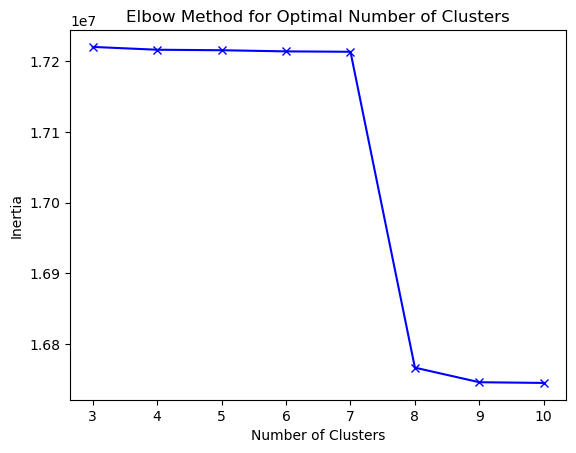

Optimal number of clusters found using Elbow Method: 8


In [36]:
import matplotlib.pyplot as plt

# Задаем список возможных значений числа кластеров
k_clusters_range = range(3, 11)

# Создаем пустой список для хранения инерции
inertias = []

for k_clusters in k_clusters_range:
    kmeans = KMeans(n_clusters=k_clusters, random_state=0)
    kmeans.fit(user_item_matrix_sparse)
    inertias.append(kmeans.inertia_)

# Визуализация метода локтя
plt.plot(k_clusters_range, inertias, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Находим оптимальное количество кластеров по методу локтя
optimal_k_clusters = k_clusters_range[np.argmin(np.diff(inertias)) + 1]  # +1 для компенсации разницы

print(f"Optimal number of clusters found using Elbow Method: {optimal_k_clusters}")

In [7]:
import pandas as pd, numpy as np, logging
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import coo_matrix
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import time, timeit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

logging.basicConfig(filename='collaborative_filtering.log', level=logging.INFO)

class ClusterCollaborativeFiltering:
    '''
        Модель коллаборативной фильтрации на основе кластеризации пользователей:

        Параметры конструктора:
           - train_data (scipy.sparse.csr_matrix): Разреженная матрица взаимодействия пользователь-объект.
           - k_clusters (int): Количество кластеров для кластеризации пользователей.
           - k_neighbors (int): Количество рассматриваемых ближайших соседей.
           - batch_size (int, по умолчанию 100): Размер партии данных для Mini-Batch KMeans.

        Методы:
           __init__(self, train_data, k_clusters, k_neighbors, batch_size=100):
               Инициализирует модель коллаборативной фильтрации.
               Обучает KMeans для кластеризации пользователей и подгоняет модели NearestNeighbors для каждого кластера.

           fit(self, X, y=None):
               Обучает модель, обновляя модели NearestNeighbors для каждого кластера на основе обучающих данных.
               Возвращает обученную модель.

           find_max_liked_users(self, user_id):
               Находит пользователей с наибольшей вероятностью понравиться указанному пользователю в том же кластере.
               Возвращает список рекомендованных пользователей.

           find_potential_matches(self, user_id):
               Находит потенциальные совпадения для указанного пользователя на основе ближайших соседей.
               Возвращает список потенциальных совпадений.

            В приведенном коде использованы блоки try-except, чтобы перехватывать и обрабатывать возможные исключения при 
        инициализации объекта, обучении модели, поиске пользователей и при запуске основной части программы. 
        Это поможет улучшить надежность и устойчивость нашей программы, а также предостеречь от внезапных сбоев
    '''

        
    def __init__(self, train_data, k_clusters, k_neighbors, batch_size=100):
        
        '''
            Модель кластеризации пользователей базируется на их поведении в датасете взаимодействий. 
            Алгоритм KMeans пытается разделить пользователей на кластеры (группы) на основе сходства их взаимодействий с объектами. 
            Подобные пользователи (например, с похожими предпочтениями или поведением) оказываются в одном кластере.

            Кластеризация проводится на основе разреженной матрицы взаимодействий пользователь-объект. 
            Какой пользователь какие объекты оценил, как оценил (лайк/дизлайк) - все это используется 
            для определения сходства пользователей и формирования кластеров.
            
            Таким образом, модель кластеризации пользователей  работает на 
            основе их взаимодействий с объектами и создает группы пользователей с похожими паттернами взаимодействия.
        '''
        try:
            #Устанавливает количество кластеров, которые будут использоваться для кластеризации пользователей.
            self.k_clusters = k_clusters
    
            #Устанавливает количество ближайших соседей, которые будут рассматриваться при поиске подходящих пользователей.
            self.k_neighbors = k_neighbors
    
            #Сохраняет разреженную матрицу взаимодействий между пользователями и объектами.
            self.train_data = train_data
    
            #Создает объект KMeans с заданным количеством кластеров и устанавливает начальное состояние генератора случайных чисел.
            self.kmeans = KMeans(n_clusters=self.k_clusters, random_state=0)
    
            #Производит кластеризацию пользователей на k_clusters кластеров и сохраняет присвоенные кластеры.
            self.cluster_assignments = self.kmeans.fit_predict(train_data)
    
            #Создает словарь, где каждому кластеру присваивается объект NearestNeighbors для поиска ближайших соседей.
            self.cluster_models = {cluster_id: NearestNeighbors(n_neighbors=self.k_neighbors+1, algorithm='brute', n_jobs=-1)
                                   for cluster_id in range(self.k_clusters)}
            
            #Для каждого кластера выполняется обучение модели NearestNeighbors на данных, принадлежащих кластеру.
            for cluster_id in range(self.k_clusters):
                cluster_data = train_data[self.cluster_assignments == cluster_id]
                self.cluster_models[cluster_id].fit(cluster_data)

        except Exception as e:
            logging.error(f"An error __init__ occurred during initialization: {e}")

    

    def fit(self, X, y=None):
        '''
            Функция для обучения модели на основе новых данных или обновления существующей модели    
        '''
        
        try:
            #Логгирование информационного сообщения о начале обучения модели.
            logging.info('Обучение модели начато...') 
    
            #Для каждого кластера в диапазоне от 0 до self.k_clusters:
            for cluster_id in range(self.k_clusters):
    
                #Выбираются данные кластера из обучающей выборки.
                cluster_data = self.train_data[self.cluster_assignments == cluster_id]
    
                #Модель NearestNeighbors для текущего кластера обучается на этих данных.
                self.cluster_models[cluster_id].fit(cluster_data)
    
            #Логгирование информационного сообщения об окончании обучения модели
            logging.info('Обучение модели завершено.')
    
            #Возвращается обученная модель self
            return self
            
        except Exception as e:
            logging.error(f"An error fit occurred during fitting the model: {e}")


    

    def find_max_liked_users(self, user_id):
        '''
            Функция для поиска пользователей с наивысшей вероятностью понравиться указанному пользователю в том же кластере.
        
            Parameters:
                - user_id: Идентификатор пользователя, для которого ищутся наиболее предпочтительные пользователи в том же кластере.
        
            Returns:
                - liked_users: Список идентификаторов пользователей с наивысшей вероятностью понравиться пользователю
           
        '''
        try:
            #Определение идентификатора кластера, к которому принадлежит указанный пользователь
            cluster_id = self.cluster_assignments[user_id]
    
            #Получение модели ближайших соседей для данного кластера.
            cluster_model = self.cluster_models[cluster_id]
    
            #Поиск ближайших соседей указанного пользователя с помощью модели.
            distances, indices = cluster_model.kneighbors(self.train_data[user_id].reshape(1, -1), n_neighbors=10)
    
            #Фильтрация найденных пользователей: сохранение только тех, кто не является текущим пользователем и имеет вероятность понравиться.
            liked_users = [user for user in indices.flatten()[1:] if user not in self.train_data[user_id].indices and user != 0]
    
            #Логирование информации о найденных пользователях с наивысшей вероятностью понравиться указанному пользователю
            logging.info(f'Найдены пользователи с максимальной вероятностью понравиться для пользователя с ID {user_id}: {liked_users}')
    
            #Возвращение списка liked_users.
            return liked_users

        except Exception as e:
            logging.error(f"An error find_max_liked_users occurred during finding max liked users: {e}")


    

    def find_potential_matches(self, user_id):
        '''
            Функция для поиска потенциальных совпадений для указанного пользователя на основе ближайших соседей в том же кластере.
        
            Parameters:
                - user_id: Идентификатор пользователя, для которого выполняется поиск потенциальных совпадений.
        
            Returns:
                - potential_matches: Список идентификаторов потенциальных совпадений для указанного пользователя.
        '''
        try:
            #Определение идентификатора кластера, к которому принадлежит указанный пользователь
            cluster_id = self.cluster_assignments[user_id]
    
            #Получение модели ближайших соседей для данного кластера
            cluster_model = self.cluster_models[cluster_id]
    
            #Поиск ближайших соседей указанного пользователя с помощью модели
            distances, indices = cluster_model.kneighbors(self.train_data[user_id].reshape(1, -1), n_neighbors=10)
    
            #Фильтрация найденных пользователей: сохранение только тех, для которых нет взаимодействия с указанным 
            # пользователем и они не представляют собой самого пользователя.
            potential_matches = [user for user in indices.flatten()[1:] if user not in self.train_data.indices and self.train_data[user_id, user] == 0 and user != 0]
            
            #Логирование информации о найденных потенциальных совпадениях для указанного пользователя.
            logging.info(f'Найдены потенциальные совпадения для пользователя с ID {user_id}: {potential_matches}')
    
            #Возвращение списка potential_matches
            return potential_matches

        except Exception as e:
            logging.error(f"An error find_potential_matches occurred during finding potential matches: {e}")



def run_collaborative_filtering():
    '''
        Функция для запуска полного процесса обработки данных и использования модели коллаборативной фильтрации.
        Вывод результатов и измерение времени выполнения.
    
        Загружает данные, подготавливает их и использует модель коллаборативной фильтрации.
        Поочередно для каждого пользователя из списка user_ids выполняет поиск пользователей с максимальной вероятностью понравиться и потенциальных совпадений.
    '''
    try:
        # Загрузка данных и подготовка:
        # Считывание двух CSV файлов: "rec-libimseti-dir.edges" и "info.csv" с помощью Pandas:
        df_ratings = pd.read_csv("rec-libimseti-dir.edges", sep='\s+', skiprows=1, names=["id_from", "id_to", "rating"]).fillna(0)
        df_info = pd.read_csv('info.csv')
    
        # Предобработка данных:
        df_info = df_info.rename(columns={' gender': 'gender'})
    
        #Преобразование категориальных данных в числовой формат с помощью LabelEncoder:
        label_encoder = LabelEncoder()
        df_info['gender'] = label_encoder.fit_transform(df_info['gender'])
        
        # Вычисление рейтинга
        # Предполагается, что рейтинг >= 6 означает лайк, иначе - дизлайк:
        threshold = 6
    
        #Преобразование рейтингов: если рейтинг больше или равен порогу, то рейтинг равен 1, иначе -1:
        LIKE = 1
        DISLIKE = -1
        df_ratings['rating'] = np.where(df_ratings['rating'] >= threshold, LIKE, DISLIKE)
    
        # Создание разреженной матрицы:
        user_item_matrix_sparse = coo_matrix((df_ratings['rating'], (df_ratings['id_from'], df_ratings['id_to']))).tocsr()
    
        # Использование коллаборативной фильтрации:
        user_ids = [98447, 111944, 111930, 82091, 125299, 125298, 17335, 60356]
        k_clusters = 8
        k_neighbors = 10
    
        #Инициализация объекта ClusterCollaborativeFiltering с созданной разреженной матрицей, количеством кластеров и числом соседей:
        clustered_collab_filter = ClusterCollaborativeFiltering(user_item_matrix_sparse, k_clusters, k_neighbors)
    
        # Для каждого пользователя из списка user_ids выполняется поиск пользователей с максимальной вероятностью 
        # понравиться и потенциальных совпадений:
        for user_id in user_ids:
            max_liked_users = clustered_collab_filter.find_max_liked_users(user_id)
            potential_matches = clustered_collab_filter.find_potential_matches(user_id)
    
            #Результаты выводятся на экран с помощью print:
            print(f"User ID: {user_id}")
            print(f"Пользователи с максимальной вероятностью понравиться: {max_liked_users}")
            print(f"Потенциальные взаимные мэтчи для пользователя: {potential_matches}")


    except Exception as e:
        logging.error(f"An error run_collaborative_filtering occurred during data loading and preprocessing: {e}")

if __name__ == '__main__':
    try:
        #функция timeit.timeit вызывается для измерения времени выполнения функции run_collaborative_filtering
        execution_time = timeit.timeit(run_collaborative_filtering, number=1)
        print(f"Время исполнения: {execution_time} секунд")

    except Exception as e:
        logging.error(f"An error call occurred during the main execution: {e}")

User ID: 98447
Пользователи с максимальной вероятностью понравиться: [45324, 49462, 2880, 76284, 330, 90352, 76146, 115553]
Потенциальные взаимные мэтчи для пользователя: [49462, 2880, 76284, 90352, 76146]
User ID: 111944
Пользователи с максимальной вероятностью понравиться: [107261, 15700, 109071, 34496, 82987, 10850, 79556, 90056]
Потенциальные взаимные мэтчи для пользователя: [107261, 15700, 109071, 34496, 79556]
User ID: 111930
Пользователи с максимальной вероятностью понравиться: [23435, 8956, 87329, 96792, 9094, 79562, 41921, 110057]
Потенциальные взаимные мэтчи для пользователя: [23435, 87329, 96792, 79562, 41921]
User ID: 82091
Пользователи с максимальной вероятностью понравиться: [99280, 45002, 67306, 113960, 101223, 73603, 38257, 98095]
Потенциальные взаимные мэтчи для пользователя: [67306, 38257, 98095]
User ID: 125299
Пользователи с максимальной вероятностью понравиться: [116881, 94450, 28558, 12506, 56904, 56532, 10110, 58769]
Потенциальные взаимные мэтчи для пользователя: